In [56]:
# PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [58]:
# read in file
dataset = pd.read_csv("Brain_GSE50161.csv")
dataset['type'] = dataset['type'].replace(['ependymoma', 'glioblastoma','medulloblastoma', 'pilocytic_astrocytoma','normal'],[0,1,2,3,4])
label = dataset.iloc[:,1]
original_features = dataset.iloc[:,2:]

In [59]:
# Normalization:
features = (original_features - np.min(original_features)) / (np.max(original_features) - np.min(original_features))

In [64]:
#PCA, Ensure that the data after dimensionality reduction maintains 90% of the information
scalar = StandardScaler()
scalar.fit(features)
scaled_data = scalar.transform(features)

pca = PCA(n_components=0.99)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

In [65]:
x_pca.shape

(130, 121)

In [71]:
#Split the data after PCA.
label = dataset.iloc[:,1]
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(x_pca, label, test_size=0.2, random_state=66)

In [72]:
#Call the package for verification on the data after PCA.
model = KNeighborsClassifier()
model.fit(pca_x_train, pca_y_train)
pca_y_pred = model.predict(pca_x_test)
print('KNN accuracy after PCA: %.2f' % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('KNN F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test, average='macro') * 100))

KNN accuracy after PCA: 84.62
KNN F1 score after PCA: 83.51


In [73]:
model = LogisticRegression(solver='lbfgs', max_iter=5000)
model.fit(pca_x_train, pca_y_train)
pca_y_pred = model.predict(pca_x_test)
print('LogisticRegression accuracy after PCA: %.2f' % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('LogisticRegression F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

LogisticRegression accuracy after PCA: 100.00
LogisticRegression F1 score after PCA: 100.00


In [74]:
nb = GaussianNB()
nb.fit(pca_x_train, pca_y_train)
pca_y_pred = nb.predict(pca_x_test)
print("Naive Bayes accuracy after PCA: %.2f" % (nb.score(pca_x_test, pca_y_test) * 100))
print('Naive Bayes F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

Naive Bayes accuracy after PCA: 80.77
Naive Bayes F1 score after PCA: 66.88


In [75]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(pca_x_train, pca_y_train)
pca_y_pred = rf.predict(pca_x_test)
print("Random Forest accuracy after PCA: %.2f" % (metrics.accuracy_score(pca_y_pred, pca_y_test) * 100))
print('Random Forest F1 score after PCA: %.2f' % (metrics.f1_score(pca_y_pred, pca_y_test,average='macro') * 100))

Random Forest accuracy after PCA: 84.62
Random Forest F1 score after PCA: 69.97


In [76]:
#Check the 3-fold cross validation results on all models.
models = {
    'KNN 3-fold cross validation': KNeighborsClassifier(),
    'LogisticRegression 3-fold cross validation': LogisticRegression(solver='lbfgs', max_iter=2000),
    'Naive Bayes 3-fold cross validation': GaussianNB(),
    'Random Forest 3-fold cross validation': RandomForestClassifier(),
}

cv = KFold(n_splits=3, random_state=66, shuffle=True)

for name, model in models.items():
    scores = cross_val_score(model, dataset, dataset["type"], cv=cv)
    
    print('%s: %.2f%%' % (name, np.mean(scores) * 100))

KNN 3-fold cross validation: 92.28%
LogisticRegression 3-fold cross validation: 96.92%
Naive Bayes 3-fold cross validation: 100.00%
Random Forest 3-fold cross validation: 93.83%


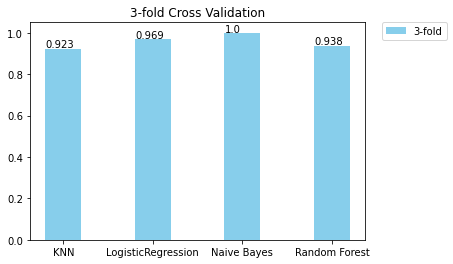

In [77]:
name_list = ['KNN', 'LogisticRegression','Naive Bayes','Random Forest']
num_list = [0.923, 0.969, 1.000, 0.938]
x =list(range(len(num_list)))
total_width, n = 0.8, 2
width = total_width / n

bars = plt.bar(x, num_list, width=width, label='3-fold', tick_label = name_list, fc = 'skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
for i in range(len(x)):
    x[i] = x[i] + width
#plt.bar(x, num_list11, width=width, label='after PCA',tick_label = name_list1,fc = 'r')
plt.title("3-fold Cross Validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()